### 1. Import Package and Data

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [308]:
df_1999 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2012 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_2014 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_2016 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_2017 = pd.read_csv("../data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

### 2. Data Cleaning

We will conduct the following action:
1. check for missing values and duplicates 
2. change `month` to date object
3. standardise string formatting in `flat_model`

In [309]:
def clean_dataset(df, dataset_name):
    """
    Cleans the dataset by identifying and removing duplicate rows and checking for missing values.

    Parameters:
    df (pd.DataFrame): The DataFrame to be cleaned.
    dataset_name (str): The name of the dataset for logging purposes.

    Returns:
    pd.DataFrame: A cleaned DataFrame with duplicates removed.
    
    Prints:
    - The number of duplicate rows found and removed.
    - The count of missing values per column.
    """
    print(f"Cleaning dataset: {dataset_name}")
    
    # Check for duplicates
    duplicates_count = df.duplicated().sum()
    print(f"{dataset_name}: Number of duplicates: {duplicates_count}")
    
    # Drop duplicates
    df_cleaned = df.drop_duplicates().copy()          
    
    # Check for missing values
    missing_values = df_cleaned.isna().sum()
    print(f"{dataset_name}: Missing values per column:")
    print(missing_values)
    
    return df_cleaned

def convert_month_to_datetime(df, column_name='month'):
    """
    Converts a column containing month information in 'YYYY-MM' format to datetime.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the month column.
    column_name (str): The name of the column with month data (default is 'Month').

    Returns:
    pd.DataFrame: The DataFrame with the specified column converted to datetime.
    """
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m')
    return df

def clean_flat_model(df):
    """
    Cleans the 'flat_model' column in the given DataFrame by removing any 
    leading or trailing whitespace and converting the text to uppercase.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the 'flat_model' column.

    Returns:
        pd.DataFrame: The modified DataFrame with the cleaned 'flat_model' column.
    """
    df['flat_model'] = df['flat_model'].str.strip().str.upper()
    return df

In [310]:
# Clean each dataset
df_1999_cleaned = clean_dataset(df_1999, "1999")
df_2012_cleaned = clean_dataset(df_2012, "2012")
df_2014_cleaned = clean_dataset(df_2014, "2014")
df_2016_cleaned = clean_dataset(df_2016, "2016")
df_2017_cleaned = clean_dataset(df_2017, "2017")

# Convert 'Month' column to datetime format in each cleaned dataset
df_1999_cleaned = convert_month_to_datetime(df_1999_cleaned)
df_2012_cleaned = convert_month_to_datetime(df_2012_cleaned)
df_2014_cleaned = convert_month_to_datetime(df_2014_cleaned)
df_2016_cleaned = convert_month_to_datetime(df_2016_cleaned)
df_2017_cleaned = convert_month_to_datetime(df_2017_cleaned)


# standardising string formating in flat_model
df_1999_cleaned = clean_flat_model(df_1999_cleaned)
df_2012_cleaned = clean_flat_model(df_2012_cleaned)
df_2014_cleaned = clean_flat_model(df_2014_cleaned)
df_2016_cleaned = clean_flat_model(df_2016_cleaned)
df_2017_cleaned = clean_flat_model(df_2017_cleaned)

Cleaning dataset: 1999
1999: Number of duplicates: 826
1999: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2012
2012: Number of duplicates: 513
2012: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2014
2014: Number of duplicates: 248
2014: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_comm

Our dataset do not contain any missing values. Hence, we will only remove the duplicates.



Then, we are checking if all the 5 datasets contain all the same columns

In [311]:
datasets = {
    "1999": df_1999_cleaned,
    "2012": df_2012_cleaned,
    "2014": df_2014_cleaned,
    "2016": df_2016_cleaned,
    "2017": df_2017_cleaned
}
for name, df in datasets.items():
    print(f"Dataset {name} columns:")
    print(df.columns)
    print("\n")

Dataset 1999 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2012 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2014 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')


Dataset 2016 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')


Dataset 2017 columns:
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
     

We can see that only the 2016 and 2017 contains the column `remaining_lease`. Hence, we will be imputing this value by calculating using 99 - （`Month` - `Lease commence date`）

In [312]:
def impute_remaining_lease(df):
    """
    Imputes 'remaining_lease' as a float with 1 decimal place based on 'lease_commence_date' and 'Month' columns,
    assuming a 99-year lease duration. The decimal part represents the fraction of the year based on months.

    Parameters:
    df (pd.DataFrame): The DataFrame where 'remaining_lease' needs to be imputed.

    Returns:
    pd.DataFrame: The DataFrame with 'remaining_lease' imputed as a float to 1 decimal place.
    """
    # Extract the current year and month from 'Month' column
    df['current_year'] = df['month'].dt.year
    df['current_month'] = df['month'].dt.month

    # Calculate the number of years and fraction of the year remaining
    years_elapsed = df['current_year'] - df['lease_commence_date']
    months_fraction = df['current_month'] / 12  # Convert months to fraction of a year

    # Calculate remaining lease as a float with 1 decimal place
    df['remaining_lease'] = (99 - years_elapsed - months_fraction).round(1)

    # Drop the temporary columns
    df.drop(columns=['current_year', 'current_month'], inplace=True)
    return df

In [313]:
# Apply to the datasets where 'remaining_lease' is missing
df_1999_cleaned = impute_remaining_lease(df_1999_cleaned)
df_2012_cleaned = impute_remaining_lease(df_2012_cleaned)
df_2014_cleaned = impute_remaining_lease(df_2014_cleaned)

In addition, some of the `remaining_lease` are string because they are stored in year, month format. For example, 95 years 07 months. We will convert it to only years which is a float of 1d.p. 

In addition, some people sale their house in advance. Hence, their `remaining_lease` > 99. In that case, we will cap it at 99.0

In [314]:
def standardize_remaining_lease(df):
    """
    Standardizes the 'remaining_lease' column in a DataFrame to a float with 1 decimal place.
    Converts from 'XX years YY months' or 'XX years' format to a float where the decimal represents the fraction of the year.
    Caps any 'remaining_lease' value at 99 years.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the 'remaining_lease' column in mixed formats.

    Returns:
    pd.DataFrame: The DataFrame with 'remaining_lease' standardized as a float with 1 decimal place and capped at 99 years.
    """
    def convert_lease(lease):
        # If the value is already a float or int, return it as-is, capped at 99
        if isinstance(lease, (float, int)):
            return min(round(float(lease), 1), 99.0)
        
        # Handle 'XX years YY months' format
        match_full = re.match(r"(\d+) years (\d+) months", lease)
        if match_full:
            years = int(match_full.group(1))
            months = int(match_full.group(2))
            remaining_lease = years + (months / 12)
            return min(round(remaining_lease, 1), 99.0)
        
        # Handle 'XX years' format only
        match_years = re.match(r"(\d+) years", lease)
        if match_years:
            years = int(match_years.group(1))
            return min(round(float(years), 1), 99.0)
        
        # Return None if the format is unexpected
        return None
    
    # Apply the conversion and capping directly to the 'remaining_lease' column
    df['remaining_lease'] = df['remaining_lease'].apply(convert_lease)
    return df

In [315]:
# Apply the function to standardize 'remaining_lease' in each cleaned dataset
df_1999_cleaned = standardize_remaining_lease(df_1999_cleaned)
df_2012_cleaned = standardize_remaining_lease(df_2012_cleaned)
df_2014_cleaned = standardize_remaining_lease(df_2014_cleaned)
df_2016_cleaned = standardize_remaining_lease(df_2016_cleaned)
df_2017_cleaned = standardize_remaining_lease(df_2017_cleaned)

#### Combining the data

In [316]:
# Full dataset
full_data = pd.concat([df_1999_cleaned, df_2012_cleaned, df_2014_cleaned, df_2016_cleaned, df_2017_cleaned], ignore_index=True)

#'MULTI-GENERATION', 'MULTI GENERATION' exits in flat_type, so all changed to 'MULTI GENERATION'
full_data['flat_type'] = full_data['flat_type'].replace('MULTI-GENERATION', 'MULTI GENERATION')

### 3. EDA part 1(Before feature engineering)

We will split it into numerical and categorical data

In [317]:
def split_categorical_numerical(df):
    """
    Splits the DataFrame into separate categorical and numerical DataFrames based on column data types.

    Parameters:
    df (pd.DataFrame): The DataFrame to be split.

    Returns:
    tuple: A tuple containing two DataFrames:
        - categorical_columns (pd.DataFrame): DataFrame of categorical columns.
        - numerical_columns (pd.DataFrame): DataFrame of numerical columns, including datetime columns.
    """
    categorical_columns = df.select_dtypes(include=['object'])
    numerical_columns = df.select_dtypes(include=['number', 'datetime64[ns]'])
    return categorical_columns, numerical_columns

In [318]:
# 1. split df_1999
full_col, full_num = split_categorical_numerical(full_data)


##### 3.1 Numerical values

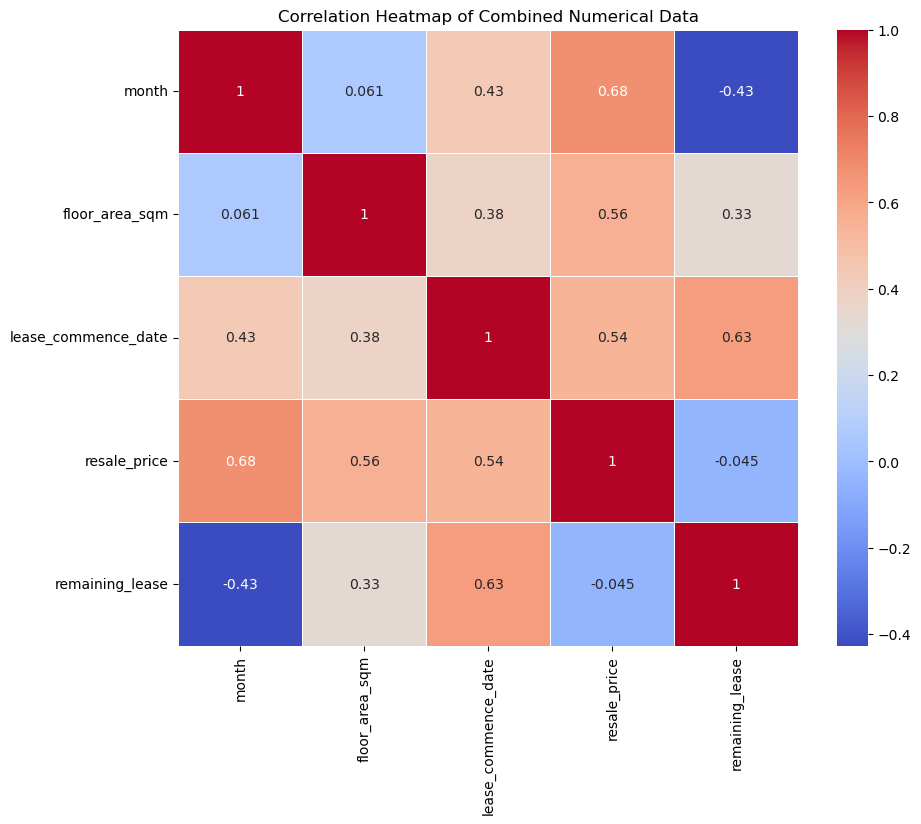

In [319]:
# creating a heat map of the numerical values
correlation_matrix = full_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Combined Numerical Data')
plt.show()

Considering `remaining_lease` if derived from `lease_commence_date` and they have a rather high correlation (**0.63**), we will drop `lease_commence_date` to keep the more insightful feature `remaining_lease`.

In [320]:
def drop_lease_commence(df):
    """
    Drops the 'lease_commence_date' column from the DataFrame if it exists, to retain only 'remaining_lease'.

    Parameters:
    df (pd.DataFrame): The DataFrame from which 'lease_commence_date' will be removed.

    Returns:
    pd.DataFrame: The DataFrame without the 'lease_commence_date' column if it was present.
    """
    return df.drop(columns=['lease_commence_date'], errors='ignore')

In [321]:
# Example usage on multiple incoming DataFrames
full_data = drop_lease_commence(full_data)

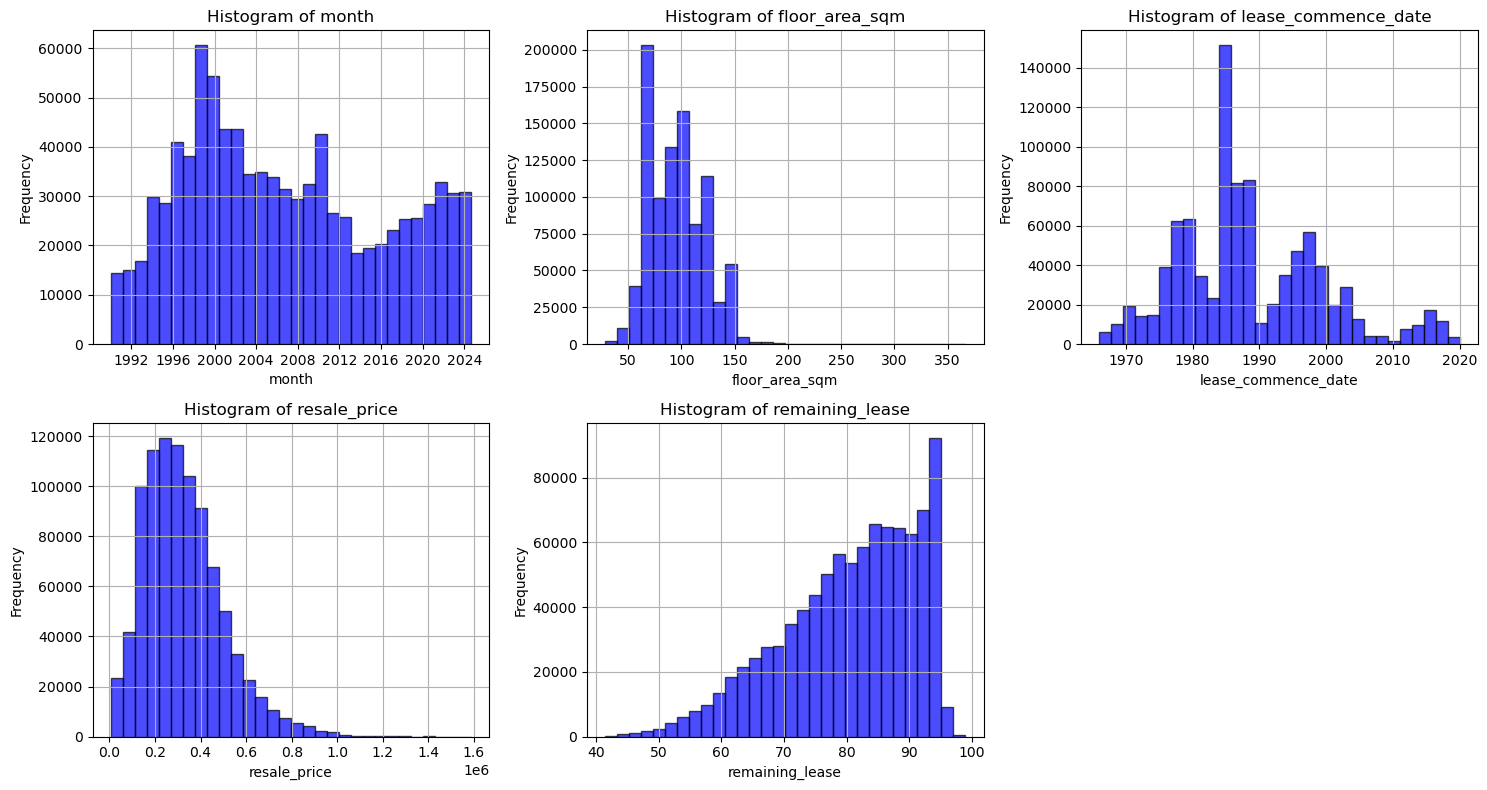

In [322]:
# Define the number of columns and rows for the grid layout
num_columns = 3  # Number of plots per row
num_plots = 5  # Total number of plots
num_rows = 2  # Number of rows needed
numerical_columns = full_num.columns

# Set the figure size
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
axes = axes.flatten()

# Plot each numerical column in a subplot
for i, column in enumerate(numerical_columns):
    axes[i].hist(full_num[column], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout to avoid overlapping text
plt.show()

##### 3.2 Categorical values

### 4. Feature Engineering

#### 4.1 Train_test_split
We will be spliting the data into 80-20 before we conduct any imputation or feature engineering.

In [323]:
X = full_data.drop(columns=['resale_price']) 
y = full_data['resale_price']

# Split the data into an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3244)


#### 4.2 New features

<span style="font-size: 14px;"> `split_storey_range` add in the columns of `lower_storey` and `upper_storey` derived from  `storey_range` </span>

<span style="font-size: 14px;"> `add_max_storey` add in the column `max_storey` for each building (at the very least the highest storey recorded)</span>

<span style="font-size: 14px;"> `calculate_age_of_flat` Calculates the `age_of_flat` for each row in the DataFrame based on the `remaining_lease`</span>

In [324]:
def split_storey_range(df):
    """
    Splits the 'storey_range' column into 'lower_storey' and 'upper_storey'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the 'storey_range' column.
    
    Returns:
    pd.DataFrame: Modified DataFrame with 'lower_storey' and 'upper_storey' columns added.
    """
    # Splitting the 'storey_range' column into 'lower_storey' and 'upper_storey'
    df[['lower_storey', 'upper_storey']] = df['storey_range'].str.split(' TO ', expand=True)

    # Convert lower_storey and upper_storey to numeric types
    df['lower_storey'] = pd.to_numeric(df['lower_storey'], errors='coerce')
    df['upper_storey'] = pd.to_numeric(df['upper_storey'], errors='coerce')

    return df

def add_max_storey(df):
    """
    Adds a column 'max_storey' to the DataFrame based on the maximum upper_storey 
    for each unique combination of town, block, and street_name.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'town', 'block', 'street_name', and 'upper_storey'.

    Returns:
    pd.DataFrame: Modified DataFrame with the new 'max_storey' column.
    """
    
    # Create max_storey column
    df['max_storey'] = df.groupby(['town', 'block', 'street_name'])['upper_storey'].transform('max')
    
    return df

def calculate_age_of_flat(row):
    """
Calculates the 'age_of_flat' for each row in the DataFrame based on the 'remaining_lease'

Parameters:
row (pd.Series): A row of the DataFrame containing 'remaining_lease', 'year',
                 'lease_commence_date', and 'month_number'.

Returns:
float: The calculated 'age_of_flat', which is set to 0 if the result is negative.
"""

    age = 99 - row['remaining_lease']
    
    return max(age, 0)

In [325]:
X_train = split_storey_range(X_train)
X_train = add_max_storey(X_train)
X_train['age_of_flat'] = X_train.apply(calculate_age_of_flat, axis=1)

#### 4.3 Label encoding

In [326]:
flat_model_order_by_average_prices = X_train.groupby('flat_model')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
flat_type_order_by_average_prices = X_train.groupby('flat_type')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
town_order_by_average_prices = X_train.groupby('town')['resale_price'].mean().reset_index().sort_values(by = 'resale_price', ascending=True)
mapping_town = {town: idx + 1 for idx, town in enumerate(town_order_by_average_prices['town'])}
mapping_flat_model = {flat_model: idx + 1 for idx, flat_model in enumerate(flat_model_order_by_average_prices['flat_model'])}
mapping_flat_type = {flat_type: idx + 1 for idx, flat_type in enumerate(flat_type_order_by_average_prices['flat_type'])}

X_train['flat_model_encoded'] = X_train['flat_model'].map(mapping_flat_model)
X_train['flat_type_encoded'] = X_train['flat_type'].map(mapping_flat_type)
X_train['town_encoded'] = X_train['town'].map(mapping_town)

KeyError: 'Column not found: resale_price'

##### 4.3.1 Street Name Encoding 
We are classifying street into cluster such as central, east, south to reduce dimension.
(reference：https://en.wikipedia.org/wiki/)


For example:
1. CENTRAL: 'TOA PAYOH', 'QUEENSTOWN', 'MARINE PARADE', 'KALLANG/WHAMPOA', 'GEYLANG','CENTRAL AREA', 'BISHAN' ,'BUKIT TIMAH','BUKIT MERAH'
2. EAST:'TAMPINES','PASIR RIS', 'BEDOK'
3. NORTH: 'YISHUN', 'LIM CHU KANG', 'WOODLANDS''SEMBAWANG'
4. NORTHEAST: 'SERANGOON', 'SENGKANG','PUNGGOL', 'HOUGANG','ANG MO KIO'
5. WEST:'JURONG WEST', 'JURONG EAST', 'CLEMENTI','CHOA CHU KANG', 'BUKIT PANJANG', 'BUKIT BATOK'

In [305]:
X_train['town'].unique()

town_to_region = {
    # Central Region
    'TOA PAYOH': 'Central',
    'QUEENSTOWN': 'Central',
    'MARINE PARADE': 'Central',
    'KALLANG/WHAMPOA': 'Central',
    'GEYLANG': 'Central',
    'CENTRAL AREA': 'Central',
    'BISHAN': 'Central',
    'BUKIT TIMAH': 'Central',
    'BUKIT MERAH': 'Central',

    # East Region
    'TAMPINES': 'East',
    'PASIR RIS': 'East',
    'BEDOK': 'East',

    # North Region
    'YISHUN': 'North',
    'LIM CHU KANG': 'North',
    'WOODLANDS': 'North',
    'SEMBAWANG': 'North',

    # Northeast Region
    'SERANGOON': 'Northeast',
    'SENGKANG': 'Northeast',
    'PUNGGOL': 'Northeast',
    'HOUGANG': 'Northeast',
    'ANG MO KIO': 'Northeast',

    # West Region
    'JURONG WEST': 'West',
    'JURONG EAST': 'West',
    'CLEMENTI': 'West',
    'CHOA CHU KANG': 'West',
    'BUKIT PANJANG': 'West',
    'BUKIT BATOK': 'West'
}

# Map the town to its region and create a new column
X_train['region'] = X_train['town'].map(town_to_region)
X_train = X_train.drop('region', axis=1)

### 5. EDA part 2 (After Feature Engineering)

#### Helper functions

`filter_building` takes in the input of (df, `town`, `block`, `street_name`), and return all the transaction related to that buildling

In [306]:
def filter_building(df, town, block, street_name):
    """
    Filters the DataFrame for listings of a specific building.

    Parameters:
    df (pd.DataFrame): The DataFrame containing property listings.
    town (str): The town of the building.
    block (int): The block number of the building.
    street_name (str): The street name of the building.

    Returns:
    pd.DataFrame: Filtered DataFrame containing listings for the specified building.
    """
    filtered_df = df[(df['town'] == town) & 
                     (df['block'] == block) & 
                     (df['street_name'] == street_name)]
    
    num_rows = len(filtered_df)
    print(f"Total number of transactions for the building: {num_rows}")
    #print(filtered_df)
    return filtered_df


##### Distribution of the maximum storey

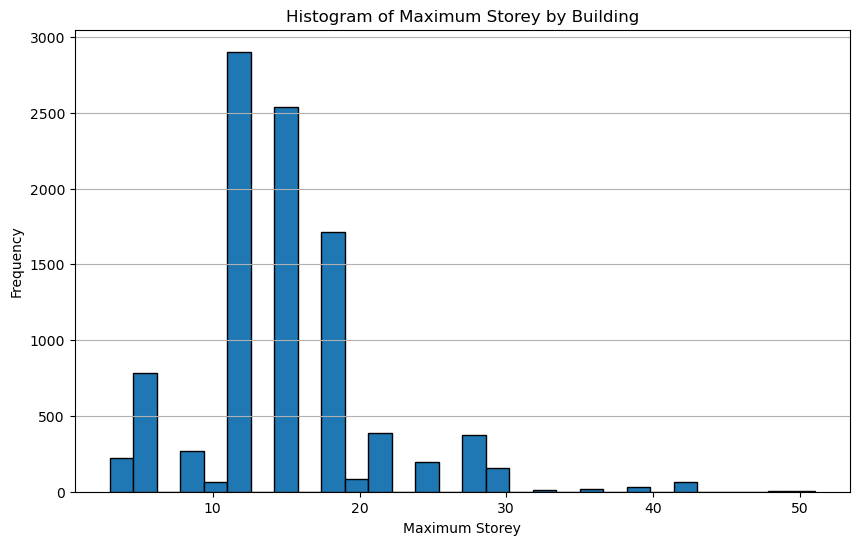

In [298]:
#Distribution of the maximum storey
lst_of_max_storey = X_train.groupby(['town', 'block', 'street_name'], as_index=False)['max_storey'].max()
# Plot the histogram of max_storey
plt.figure(figsize=(10, 6))
plt.hist(lst_of_max_storey['max_storey'], bins=30, edgecolor='black')
plt.title('Histogram of Maximum Storey by Building')
plt.xlabel('Maximum Storey')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

##### Distribution of age of flat when sold

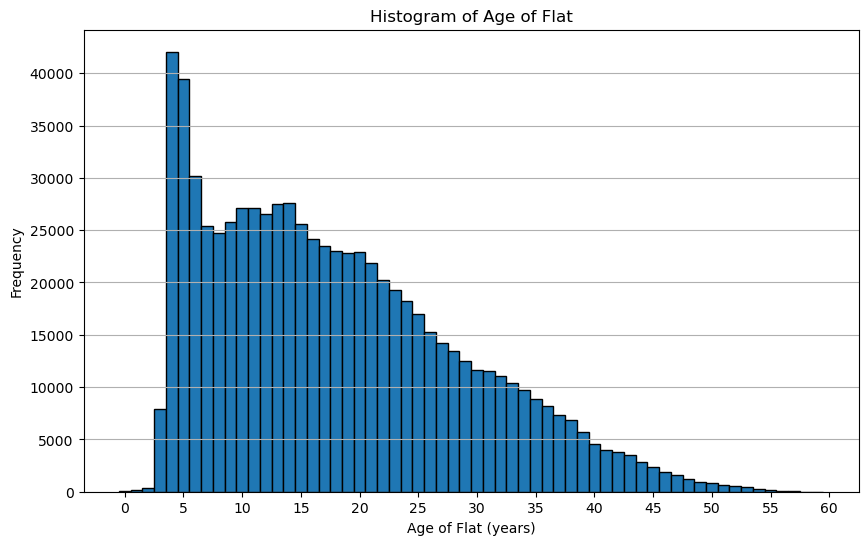

In [299]:
bins = np.arange(0, 61, 1)  # Creates bins from 0 to 60 with a width of 1

# Plot the histogram with individual bins
plt.figure(figsize=(10, 6))
plt.hist(X_train['age_of_flat'], bins=bins, edgecolor='black', align='left')
plt.title('Histogram of Age of Flat')
plt.xlabel('Age of Flat (years)')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 61, 5))  # Optional: Set x-ticks at intervals of 5 for clarity
plt.grid(axis='y')
plt.show()

##### Number of unique buildings

In [300]:
# Count unique buildings based on town, block, and street_name
unique_buildings_count = X_train.groupby(['town', 'block', 'street_name']).size().count()

# Display the total number of unique buildings
print(f"Total number of unique buildings: {unique_buildings_count}")

Total number of unique buildings: 9842


##### Data exploration using filter_building

In [301]:
# input: (df, 'town', 'block', 'street_name'); case-sensitve 
filter_building(X_train, 'KALLANG/WHAMPOA', '28', 'JLN BAHAGIA')

Total number of transactions for the building: 129


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,remaining_lease,lower_storey,upper_storey,max_storey,age_of_flat
482179,2005-12-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,01 TO 03,53.0,STANDARD,64.0,1,3,12,35.0
1004,1990-01-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,79.9,7,9,12,19.1
310393,2000-09-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,04 TO 06,56.0,STANDARD,69.2,4,6,12,29.8
559204,2008-10-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,04 TO 06,56.0,STANDARD,61.2,4,6,12,37.8
561630,2008-11-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,01 TO 03,53.0,STANDARD,61.1,1,3,12,37.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799826,2019-08-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,10 TO 12,56.0,STANDARD,50.4,10,12,12,48.6
621637,2010-09-01,KALLANG/WHAMPOA,4 ROOM,28,JLN BAHAGIA,04 TO 06,112.0,ADJOINED FLAT,59.2,4,6,12,39.8
193973,1998-05-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,71.6,7,9,12,27.4
133020,1996-08-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,01 TO 03,53.0,STANDARD,73.3,1,3,12,25.7


Eg of a building that was scheduled for en-bloc hence last transaction date is up till 1999 only, as afterward the building is demolished

In [302]:
filter_building(X_train, 'ANG MO KIO', '309', 'ANG MO KIO AVE 1')

Total number of transactions for the building: 173


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,remaining_lease,lower_storey,upper_storey,max_storey,age_of_flat
33008,1992-08-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,01 TO 03,31.0,IMPROVED,83.3,1,3,12,15.7
272665,1999-09-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,76.2,4,6,12,22.8
52936,1993-11-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,82.1,7,9,12,16.9
8671,1990-09-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,85.2,7,9,12,13.8
111282,1996-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,79.9,4,6,12,19.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280236,1999-11-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,76.1,10,12,12,22.9
119843,1996-04-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,79.7,4,6,12,19.3
148663,1997-02-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,01 TO 03,31.0,IMPROVED,78.8,1,3,12,20.2
12427,1991-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,01 TO 03,31.0,IMPROVED,84.9,1,3,12,14.1


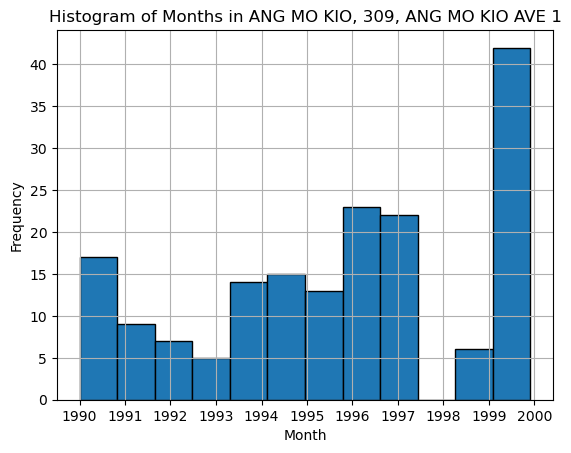

In [303]:
# Filter the DataFrame to select the area 'ANG MO KIO', '309', 'ANG MO KIO AVE 1'
selected_area = X_train.loc[(X_train['town'] == 'ANG MO KIO') &
                                 (X_train['block'] == '309') &
                                 (X_train['street_name'] == 'ANG MO KIO AVE 1')]

# Plot a histogram of the 'month' column in the selected area
selected_area['month'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Months in ANG MO KIO, 309, ANG MO KIO AVE 1')
plt.show()

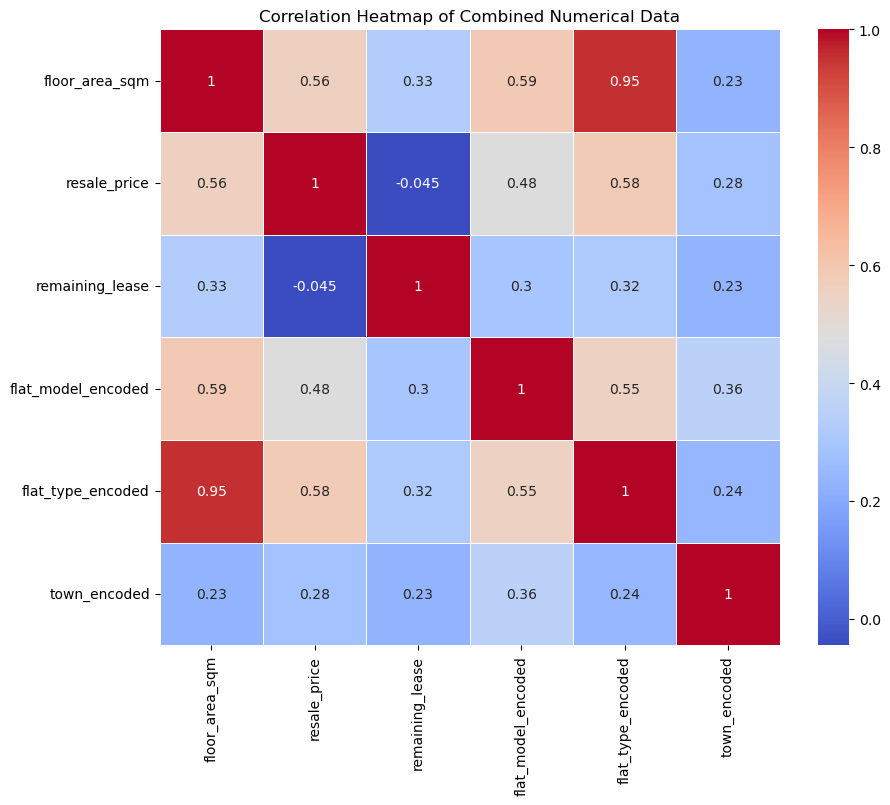

In [304]:
numeric_df = X_train._get_numeric_data()
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Combined Numerical Data')
plt.show()

In [ ]:
#linear regression model
# Define the feature matrix (X) and target variable (y)
features = [
    'floor_area_sqm', 'lease_commence_date',
    'flat_type_encoded', 'flat_model_encoded', 'town_encoded',
    'lower_storey', 'upper_storey', 'max_storey'
]


# Initialize and train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

### 6. Saving processed file for model building

In [327]:
# Saving y_train and y_test directly
y_train.to_csv("../data/y_train.csv", index=False)
y_test.to_csv("../data/y_test.csv", index=False)
X_test.to_csv("../data/X_test.csv", index=False)

# Splitting X_train into three parts and saving each part
split_size = len(X_train) // 3  # Calculate the split size

# Save the first part
X_train[:split_size].to_csv("../data/X_train_part1.csv", index=False)

# Save the second part
X_train[split_size:2*split_size].to_csv("../data/X_train_part2.csv", index=False)

# Save the third part
X_train[2*split_size:].to_csv("../data/X_train_part3.csv", index=False)